### OPTICS

&nbsp;

OPTICS is a variation of DBSCAN. One of the biggest malaises for DBSCAN is to find the appropriate ε. OPTICS uses a special ordering based upon the organic order and the reachability distance to skip the needle search of optimal ε in the haystack. Although the quadratic time complexity of the algorithm can be avoided with the input of ε. As a result of quid pro quoi, ξ is a new parameter to determine the steep upward and downward areas in reachability plot. The valleys between steep upward and downward areas would be identified as clusters.

For technical details of DBSCAN, you can click the link below.

https://github.com/je-suis-tm/machine-learning/blob/master/dbscan.ipynb

For technical details of OPTICS, you can read the original paper.

https://www.dbs.ifi.lmu.de/Publikationen/Papers/OPTICS.pdf

&nbsp;

In [1]:
import sklearn.cluster
import sklearn.decomposition
import sklearn.datasets
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.spatial

In [2]:
#compute euclidean distance matrix
def get_distance_matrix(data,use_scipy=True):
    
    #you can use scipy spatial matrix to achieve better performance
    if use_scipy:
        return scipy.spatial.distance_matrix(data,data)

    #initialize
    dist_mat=np.empty((len(data),len(data)))
    dist_mat.fill(float('inf'))

    #computing only upper triangle matrix to boost efficiency
    for i in range(len(data)):
        for j in range(i+1,len(data)):
            euclidean_dist=sum((data[j]-data[i])**2)**0.5
            dist_mat[i][j]=euclidean_dist
            dist_mat[j][i]=euclidean_dist
        
    return dist_mat

In [3]:
#prepare core distance for ordering
#based upon definition 5 in the original paper
def get_core_dist(dist_mat,minpts):

    #computing core distance
    #basically the minimum epsilon to make a random point core
    #a core point must have at least minpts points within the radius of epsilon
    #thus core distance would be the minpts-th data inside the distance matrix
    core_dist=[sorted(dist_mat[i])[minpts-1] for i in range(len(dist_mat))]
                        
    return core_dist

In [4]:
#the idea of ordering by reachability distance
#can be thought of as mapping high dimensional data into one dimension
#data points with small reachability distance become neighbors on one axis
#then we determine the area of clusters on one axis based upon ξ and minpts
#based upon figure 6 and 7 in the original paper
def order_points(core_dist,dist_mat):

    ordering=[]
    reach_dist=[]
    priority_queue=dict(zip(range(len(core_dist)),
                            [float('inf')]*len(core_dist)))
    pred=dict(zip(range(len(core_dist)),
                            [-1]*len(core_dist)))

    while priority_queue:

        #while iterating through the priority queue
        #pick the data point with the smallest reachability distance
        ind=list(priority_queue.keys())[0]
        ordering.append(ind)
        reach_dist.append(priority_queue[ind])

        #current data point has been processed
        del priority_queue[ind]

        #definition 1 in the original paper
        for i in np.where(core_dist[ind]>=dist_mat[ind])[0]:
            
            #each data point is only processed once
            if i not in ordering:
                
                #definition 6 in the original paper
                reachability=np.array([max(core_dist[ind],
                                           dist_mat[i][ind]) for i in range(len(core_dist))])
                
                #always update the smallest reachability distance
                for j in priority_queue:
                    if priority_queue[j]>reachability[j]:
                        priority_queue[j]=reachability[j]
                        pred[j]=ind
                        
        #sort the queue by reachability distance
        priority_queue=dict(sorted(priority_queue.items(),key=lambda x:x[1]))
        
    return ordering,reach_dist,pred

In [5]:
#get upward and downward areas based upon definition 10 in the original paper
def get_up_down_areas(reach_dist_df,minpts):

    start=None;end=None
    steep_areas=[]

    #detect steep areas regardless of upward/downward
    for i in range(len(reach_dist_df)):

        if start!=None:

            #inside the steep areas
            #reachability distance change should be the same direction
            sign_condition=reach_dist_df.at[i,'xi']*reach_dist_df.at[start,'xi']>=0

            #inside the steep areas
            #there should not be more than minpts consecutive non-ξ data points
            #otherwise they can form a cluster
            core_condition='0'*minpts not in ''.join(reach_dist_df['xi'].loc[start:i].astype(str))

            #both start and end should be the same direction
            xi_condition=reach_dist_df.at[i,'xi']==reach_dist_df.at[start,'xi']

            #only increment when both conditions are met
            if sign_condition and core_condition:

                #new end identified
                if xi_condition:
                    end=i  

            #one steep area is identified
            else:

                #only add steep area when we have more than one ξ data point
                #except beginning and ending
                if start!=None and end!=None:
                    steep_areas.append([start,end])
                start=None;end=None

        #should not use else condition
        #when if current data point has opposite ξ to start
        #current data point should become the new start
        if start==None:        
            if reach_dist_df.at[i,'xi']!=0:
                start=i

    #end of dataframe append
    if start!=None and end!=None:
        steep_areas.append([start,end])

    #differentiate upward and downward areas
    up_areas=[]
    down_areas=[]
    for i in steep_areas:
        if reach_dist_df.at[i[0],'xi']==1:
            up_areas.append(i)
        else:
            down_areas.append(i)
            
    #the beginning is always downward area
    if down_areas[0][0]!=0:
        down_areas.insert(0,[0,0])
    
    #the ending is always upward area
    if up_areas[-1][-1]!=reach_dist_df.index[-1]:
        up_areas.append([reach_dist_df.index[-1],reach_dist_df.index[-1]])

    return up_areas,down_areas

In [6]:
#get clusters based upon definition 11 in the original paper
def identify_cluster_structure(up_areas,down_areas,reach_dist,xi,minpts):
    
    #add the last data point to avoid empty in between sequence
    reach_plot=reach_dist+[float('inf')]
    
    clusters=[]
    for i in down_areas:

        start_down=i[0]
        end_down=i[-1]
        
        #up areas start must be larger than down areas end
        valid_up_areas=[ii for ii in up_areas if ii[0]>end_down]

        for j in valid_up_areas:

            start_up=j[0]
            end_up=j[-1]
            
            #condition 3b
            mib=max(reach_plot[start_down+1:end_up])
            sc_1_star=mib<=reach_plot[start_down]*(1-xi)
            sc_2_star=mib<=reach_plot[end_up]*(1-xi)        

            if sc_1_star and sc_2_star:
                
                #condition 4
                fig_18_b=reach_plot[start_down]*(1-xi)>=reach_plot[end_up+1]
                fig_18_a=reach_plot[end_up+1]*(1-xi)>=reach_plot[start_down]

                if fig_18_b:
                    down_areas_mib=max([ii for ii in reach_plot[start_down:end_down+1] if ii>reach_plot[end_up+1]])
                    cluster_start=start_down+reach_plot[start_down:end_down+1].index(down_areas_mib)
                    cluster_end=end_up
                elif fig_18_a:
                    cluster_start=start_down
                    up_areas_mib=min([ii for ii in reach_plot[start_up:end_up+1] if ii<reach_plot[start_down]])
                    cluster_end=start_up+reach_plot[start_up:end_up+1].index(up_areas_mib)
                else:
                    cluster_start=start_down
                    cluster_end=end_up

                #condition 3a
                if cluster_end-cluster_start>minpts-1:
                    clusters.append([cluster_start,cluster_end])
                    
    return clusters

In [7]:
#sklearn uses a cluster correction algorithm
#based upon a paper called Improving the Cluster Structure Extracted from OPTICS Plots
# http://ceur-ws.org/Vol-2191/paper37.pdf
def cluster_correction(start,end,reach_dist,pred):
    while start<end:
        if reach_dist[start]>reach_dist[end]:
            return [start,end]
        for i in range(start,end):
            if i==pred(end):
                return [start,end]
        end-=1
    return []

In [8]:
#think of it as extracting maximal cliques from cliques
#as we have used greedy search to get all potential clusters
#the maximal cluster is the biggest cluster end given the same cluster start
def get_maximal_clusters(clusters):
    
    maximal_clusters=[]
    cluster_starts=[i[0] for i in clusters]

    #start with the smallest cluster start
    #obtain the largest cluster end given the cluster start
    #remove any invalid cluster start smaller than the cluster end
    #iterate until all maximal clusters are found
    while cluster_starts:
        cluster_start=sorted(cluster_starts)[0]
        cluster_end=max([ii[1] for ii in clusters if ii[0]==cluster_start])
        maximal_clusters.append([cluster_start,cluster_end])
        cluster_starts=[i for i in cluster_starts if i>cluster_end]
        
    return maximal_clusters

In [9]:
#use optics to forecast the cluster structure
def optics_forecast(data,minpts,xi,viz_reach_plot=True):

    #prepare distance matrix and core distance
    dist_mat=get_distance_matrix(data)
    core_dist=get_core_dist(dist_mat,minpts)

    #due to the python float issue
    #the ordering isnt exactly the same as sklearn
    ordering,reach_dist,pred=order_points(core_dist,
                                          dist_mat)

    if viz_reach_plot:
        fig=plt.figure(figsize=(10,5))
        ax=fig.add_subplot(111)
        plt.bar(range(0,len(ordering)),
                reach_dist,color='#05a96f',
                width=1)
        plt.title('OPTICS Reachability Plot')
        plt.xlabel('Cluster Ordering')
        plt.xlabel('Reachability Distance')
        plt.show()

    #i know dataframe is slower numpy array
    #but its much more convenient in python
    #as we dont really reinvent the wheel in practice
    #the performance does not matter in our demonstration
    reach_dist_df=pd.DataFrame()
    reach_dist_df['data']=reach_dist

    #determine ξ steep points
    reach_dist_df['pct']=reach_dist_df['data'].pct_change().shift(-1)
    reach_dist_df['xi']=pd.Series(
        np.select([reach_dist_df['pct']>=xi,
                   reach_dist_df['pct']<=-xi],[1,-1]))

    #set the last one upward point
    reach_dist_df.at[len(reach_dist)-1,'xi']=1

    #unlike figure 19 in the original paper
    #we scan all upward/downward areas based upon definition 10
    up_areas,down_areas=get_up_down_areas(reach_dist_df,
                                          minpts)
    
    #then we scan all potential clusters based upon definition 11
    clusters=identify_cluster_structure(up_areas,
                                        down_areas,
                                        reach_dist,
                                        xi,minpts)
    
    #cluster correction
    for ind,val in enumerate(clusters):
        new_cluster=cluster_correction(val[0],val[1],reach_dist,pred)
        if new_cluster:
            clusters[ind]=new_cluster
 
    maximal_clusters=get_maximal_clusters(clusters)

    #make forecast based upon maximal clusters
    projection=np.empty(len(core_dist))

    #those who do not fit in become noise
    projection.fill(-1)
    for ind,val in enumerate(maximal_clusters):
        projection[ordering[val[0]:val[1]+1]]=ind
    
    return projection

In [10]:
#aggregate all functions into one big main function
def xi_optics(df,xcol,minpts,xi,
              viz_reach_plot=True,
              viz_iris_plot=True):
    
    data=df.copy()
    data['predict']=optics_forecast(np.array(data[xcol]),minpts,xi,
                                   viz_reach_plot=viz_reach_plot)
    
    #compute accuracy
    erreur=0
    checked=[]
    for i in data['y'].unique():
        erreur+=get_accuracy(data,i,checked)
        checked.append(i)
    accuracy=1-erreur/len(df)
    print('accuracy: %s'%(accuracy))
    
    #plot iris in 2d
    if viz_iris_plot:
        plot_iris(data,xcol)

In [11]:
#for unsupervised learning, clf.score doesnt return the accuracy
#there is no cross validation, no known labels
#the only way to detect the accuracy is vote of the majority
#for each label given
#we check which iris type is the majority
#we consider the majority as the correct classification
#all we need to do is to count the minority
def get_accuracy(data,class_,checked):
    
    df=data.copy()
    
    #use dictionary to keep track of everything
    d={}
    
    #counting
    for i in df['predict'][df['y']==class_].unique():
        if i not in checked and i!=-1:
            d[i]=df['predict'][df['y']==class_].tolist().count(i)

    #comparison
    large=-1
    lbl=None
    for i in d:
        if d[i]>large:
            lbl=i
            large=d[i]

    return len(df['predict'][df['y']==class_][df['predict']!=lbl])

In [12]:
#optics implemented by sklearn
def skl_optics(df,xcol,minpts,xi,
               viz_reach_plot=True,
              viz_iris_plot=True):
    
    data=df.copy()
    
    #machine learning
    clf=sklearn.cluster.OPTICS(min_samples=minpts,xi=xi)
    clf.fit(data[xcol])    
    data['predict']=clf.fit_predict(data[xcol])
    
    #reachability plot
    if viz_reach_plot:
        fig=plt.figure(figsize=(10,5))
        ax=fig.add_subplot(111)
        plt.bar(range(0,len(clf.ordering_)),
                clf.reachability_[clf.ordering_],
                color='#9abbe3',
                width=1)
        plt.title('OPTICS Reachability Plot')
        plt.xlabel('Cluster Ordering')
        plt.xlabel('Reachability Distance')
        plt.show()
    
    #compute accuracy
    erreur=0
    checked=[]
    for i in data['predict'].unique():
        erreur+=get_accuracy(data,i,checked)
        checked.append(i)
    accuracy=1-erreur/len(data)
    print('accuracy: %s'%(accuracy))
    
    #plot iris in 2d
    if viz_iris_plot:
        plot_iris(data,xcol)

In [13]:
#plot iris cluster in 2 dimensions
def plot_iris(df,xcol):

    #for the purpose of visualization
    #we reduce 4 dimensions to 2
    #check the link below for more details of pca
    # https://github.com/je-suis-tm/machine-learning/blob/master/principal%20component%20analysis.ipynb
    dims=2
    x=sklearn.decomposition.PCA(n_components=dims).fit_transform(df[xcol])

    df['dim1']=x[:,0]
    df['dim2']=x[:,1]

    #viz
    fig=plt.figure(figsize=(10,5))
    ax=fig.add_subplot(111)

    for i in set(df['predict']):
        if i!=-1:
            plt.scatter(df['dim1'][df['predict']==i],
                        df['dim2'][df['predict']==i],
                        label=f'Label {int(i)}',alpha=0.7)
        else:
            plt.scatter(df['dim1'][df['predict']==i],
                        df['dim2'][df['predict']==i],
                        label='Noise',alpha=0.7)

    plt.title('OPTICS')
    plt.legend(loc=0)
    plt.show()

In [14]:
#create dataframe
xcol=['x0','x1','x2','x3']
ycol='y'
iris=sklearn.datasets.load_iris()
df=pd.DataFrame(iris.data,columns=xcol)

In [15]:
#each input factor has to be float/int
#sklearn has already done that for us
#but if you are using the dataset inside the repository
#you can use np.unique to convert categorical data to int
df[ycol]=iris.target

In [16]:
#minpts denotes the minimum requirement to form a cluster
#minpts should be larger than 2
#there are different empirical rules
#it can be 2 times dimensions
#or it can be dimensions+1
minpts=1+len(xcol)

In [17]:
#ξ determines the steep upward and downward areas in reachability plot
#the valleys between steep upward and downward areas
#would be identified as clusters
#the optimal ξ is the elephant in the room
#nobody fucking talks about it!!!!
#let me know if you have found any good method for that
xi=0.05

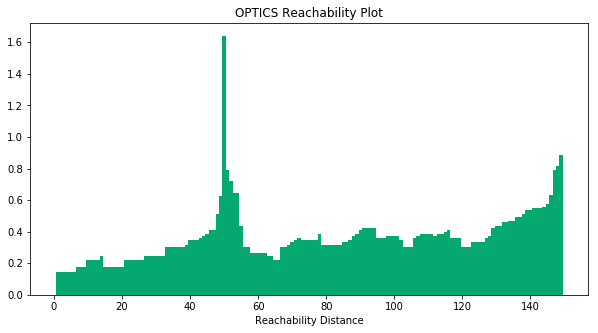

accuracy: 0.6666666666666667


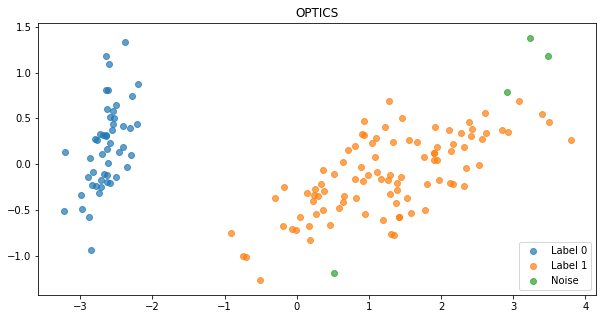

In [18]:
#surprisingly result is similar to self implemented dbscan
xi_optics(df,xcol,minpts,xi,
          viz_reach_plot=True,viz_iris_plot=True)

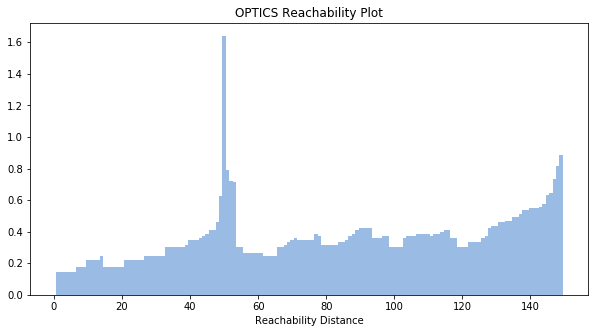

accuracy: 0.26


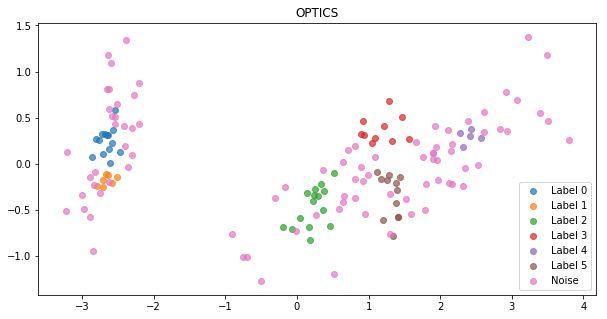

In [19]:
#even though the ordering looks similar
#it creates a lot more clusters than self implemented optics
skl_optics(df,xcol,minpts,xi,
           viz_reach_plot=True,viz_iris_plot=True)